# **Pure MCTS**

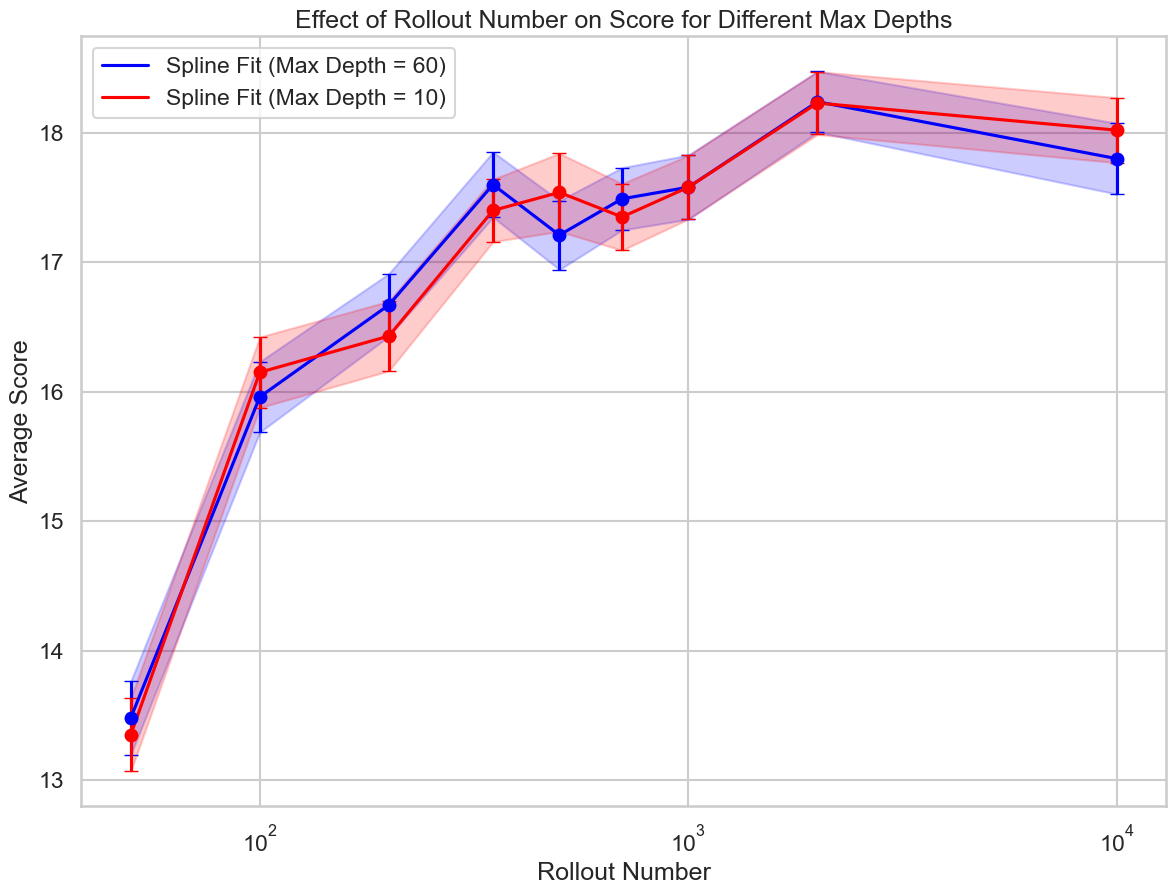

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns

# Data
rollout_numbers = np.array([50, 100, 200, 350, 500, 700, 1000, 2000, 10000])

average_scores_60 = np.array([13.48, 15.96, 16.67, 17.6, 17.21, 17.49, 17.58, 18.24, 17.8])
std_errors_60 = np.array([0.2837, 0.2727, 0.2421, 0.2519 ,0.2666, 0.2410, 0.2483, 0.2350, 0.2739])

average_scores_10 = np.array([13.35, 16.15, 16.43, 17.4, 17.54, 17.35, 17.58, 18.23, 18.02])
std_errors_10 = np.array([0.2819, 0.2729, 0.2692, 0.2412, 0.3018, 0.2574, 0.2454, 0.2428, 0.2510])

# Interpolation in log space
log_rollout_numbers = np.log(rollout_numbers)
log_rollout_numbers_fine = np.linspace(log_rollout_numbers.min(), log_rollout_numbers.max(), 500)
rollout_numbers_fine = np.exp(log_rollout_numbers_fine)

# Interpolate average scores
spl_60 = make_interp_spline(log_rollout_numbers, average_scores_60, k=1)
average_scores_60_smooth = spl_60(log_rollout_numbers_fine)

spl_10 = make_interp_spline(log_rollout_numbers, average_scores_10, k=1)
average_scores_10_smooth = spl_10(log_rollout_numbers_fine)

# Compute upper and lower bounds for standard error
upper_60 = average_scores_60 + std_errors_60
lower_60 = average_scores_60 - std_errors_60

upper_10 = average_scores_10 + std_errors_10
lower_10 = average_scores_10 - std_errors_10

# Interpolate upper and lower bounds
spl_upper_60 = make_interp_spline(log_rollout_numbers, upper_60, k=1)
spl_lower_60 = make_interp_spline(log_rollout_numbers, lower_60, k=1)
upper_60_smooth = spl_upper_60(log_rollout_numbers_fine)
lower_60_smooth = spl_lower_60(log_rollout_numbers_fine)

spl_upper_10 = make_interp_spline(log_rollout_numbers, upper_10, k=1)
spl_lower_10 = make_interp_spline(log_rollout_numbers, lower_10, k=1)
upper_10_smooth = spl_upper_10(log_rollout_numbers_fine)
lower_10_smooth = spl_lower_10(log_rollout_numbers_fine)

# Plotting
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(14,10))

# Plot the data points with error bars
plt.errorbar(rollout_numbers, average_scores_60, yerr=std_errors_60, fmt='o', capsize=5, color='blue')
plt.errorbar(rollout_numbers, average_scores_10, yerr=std_errors_10, fmt='o', capsize=5, color='red')

# Plot the interpolated lines
plt.plot(rollout_numbers_fine, average_scores_60_smooth, label='Spline Fit (Max Depth = 60)', color='blue')
plt.plot(rollout_numbers_fine, average_scores_10_smooth, label='Spline Fit (Max Depth = 10)', color='red')

# Fill between upper and lower bounds to represent standard error
plt.fill_between(rollout_numbers_fine, lower_60_smooth, upper_60_smooth, alpha=0.2, color='blue')
plt.fill_between(rollout_numbers_fine, lower_10_smooth, upper_10_smooth, alpha=0.2, color='red')

# Customize the plot
plt.xscale('log')
plt.xlabel('Rollout Number')
plt.ylabel('Average Score')
plt.title('Effect of Rollout Number on Score for Different Max Depths')
plt.legend()
plt.show()

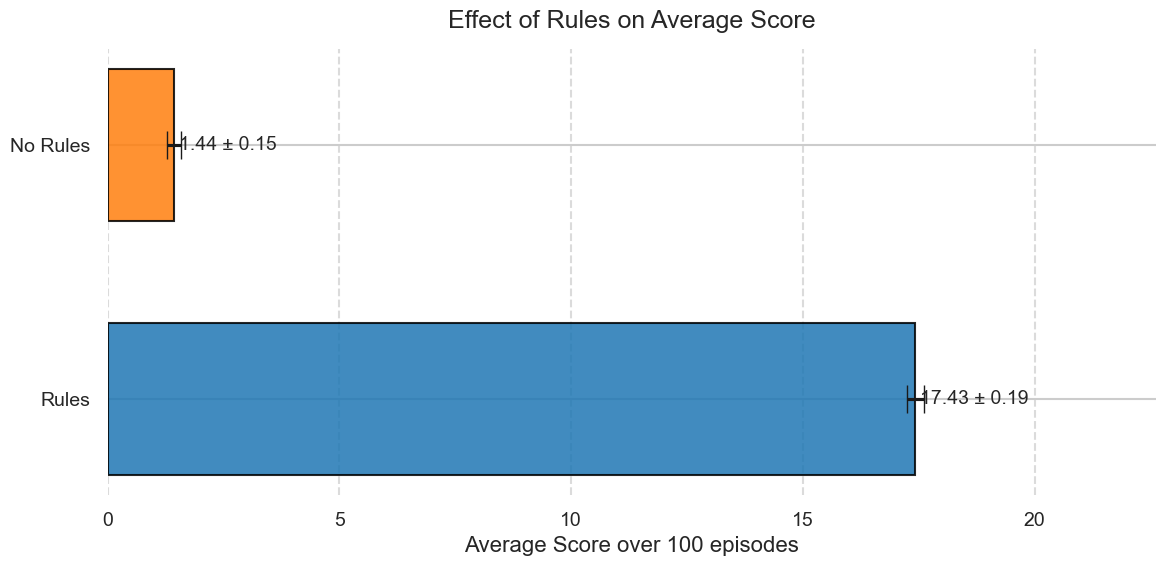

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data
values = [17.43, 1.44]
std_errors = [0.19, 0.15]
labels = ['Rules', 'No Rules']

# Set up the figure and axes
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(12, 6))

# Create a horizontal bar plot
bars = plt.barh(labels, values, xerr=std_errors, capsize=10, height=0.6,
                color=['#1f77b4', '#ff7f0e'], alpha=0.85, edgecolor='black')

# Add annotations for the values and standard errors
for bar, value, err in zip(bars, values, std_errors):
    width = bar.get_width()
    plt.text(width + max(std_errors)*0.5, bar.get_y() + bar.get_height()/2,
             f'{value:.2f} ± {err:.2f}', va='center', fontsize=14)

# Customize the plot aesthetics
plt.xlabel('Average Score over 100 episodes', fontsize=16)
plt.title('Effect of Rules on Average Score', fontsize=18, pad=15)
plt.xlim(0, values[0] + std_errors[0] + 5)

# Remove spines and ticks for a cleaner look
sns.despine(left=True, bottom=True)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Add subtle grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()